# RECOMENDACIONES DE ANALISTAS / TARGETS DE PRECIO

Otorga funcionalidades para obtener y procesar las recomendaciones de analistas del mercado sobre activos de renta variable. APIs de FMP Cloud y FinnHub.

## INDICE DE FUNCIONES:
- getAFRating(symbol, añoDesde, añoHasta, ponderacion = "igual", timeframe = "semanal"):
    Esta función permite obtener datos y graficar la evolución del rating de un activo por sus fundamentals según la API de FMP Cloud.
    Ofrece el puntaje según 5 ratios: 
        # - Valuación de Flujo de Fondos (DCF)
        # - Return on Equity (ROE)
        # - Return on Assets (ROA)
        # - Deuda sobre PN (DE)
        # - Precio sobre Ganancias (PER)
        # - Precio sobre Valor Libro (PB)
    Se puede setear año desde, año hasta y el tipo de ponderación:
    API de FMP Cloud.
    
- getRecommendationFH(symbol):
    Esta función devuelve las recomendaciones de los analistas para determinado activo según la API de FinnHub. Internamente trabaja un
    sistema de puntajes para obtener un valor en Base 10 (1 al 10) rankeando qué tan buenas perspectivas tiene el activo. Asimismo es
    posible consultar la data de la cantidad y porcentajes de opiniones en cada acción recomendada (strong buy, buy, hold, sell, strong sell).


In [2]:
def getAFRating(symbol, añoDesde, añoHasta, ponderacion = "igual", timeframe = "semanal"):
    """
    Esta función permite obtener datos y graficar la evolución del rating de un activo por sus fundamentals según la API de FMP Cloud.
    Ofrece el puntaje según 5 ratios: 
        # - Valuación de Flujo de Fondos (DCF)
        # - Return on Equity (ROE)
        # - Return on Assets (ROA)
        # - Deuda sobre PN (DE)
        # - Precio sobre Ganancias (PER)
        # - Precio sobre Valor Libro (PB)
    Se puede setear año desde, año hasta y el tipo de ponderación:
    API de FMP Cloud.
    
    # Inputs:
        - symbol: ticker del activo;
        - ponderacion: puede ser "igual" (equiponderado) o bien "custom" (ponderación distinta ya prefijada para cada tipo de valuación);
        - añoDesde: año fecha desde;
        - añoHasta: año fecha hasta;
        - timeframe: puede ser "mensual" o "semanal";
    
    # Outputs:
        - df_score: dataframe con la evolución de los datos del rating;
        - fig: gráfico con la evolución de los datos del rating;
           
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime
    import requests
    import json
    
    recommendations = ['ratingRecommendation','ratingDetailsDCFRecommendation',
                       'ratingDetailsROERecommendation','ratingDetailsROARecommendation',
                       'ratingDetailsDERecommendation','ratingDetailsPERecommendation',
                       'ratingDetailsPBRecommendation']
    
    ratings = ['ratingRecommendation','ratingDetailsDCFScore', 'ratingDetailsROEScore', 
               'ratingDetailsROAScore', 'ratingDetailsDEScore', 'ratingDetailsPEScore',
               'ratingDetailsPBScore']
    
    apikey = "66c44b016256f8b9e507838f32434ece"
    url = f"https://fmpcloud.io/api/v3/historical-rating/{symbol}"
    p = {"apikey" : apikey}
    r = requests.get(url, params = p)
    js = r.json()
    df = pd.DataFrame(js)
    df = df.set_index("date")
    df = df.drop(["symbol"], axis = 1)
    df.index = pd.to_datetime(df.index)
    df = df.loc[(df.index >= str(añoDesde)) & (df.index <= str(añoHasta))]
    if timeframe == "semanal":
        df = df.resample("1W").last()
    elif timeframe == "mensual":
        df = df.resample("1M").last()
    
    # Determinamos ponderaciones a utilizar
    if ponderacion == "igual":
        p = {"DCF" : 0.1667, "ROE" : 0.1667, "ROA": 0.1667, "DE": 0.1667, "PE": 0.1667, "PB": 0.1667}
    elif ponderacion == "custom":
        p = {"DCF" : 0.25, "ROE" : 0.10, "ROA": 0.1, "DE": 0.15, "PE": 0.20, "PB": 0.20}
    
    # Calculamos score ponderado (o equiponderado)
    score = df["ratingDetailsDCFScore"] * p["DCF"]
    score += df["ratingDetailsROEScore"] * p["ROE"]
    score += df["ratingDetailsROAScore"] * p["ROA"]
    score += df["ratingDetailsDEScore"] * p["DE"]
    score += df["ratingDetailsPEScore"] * p["PE"]
    score += df["ratingDetailsPBScore"] * p["PB"]
    score_df = pd.DataFrame(score)
    score_df.rename(columns = {"ratingDetailsDCFScore" : "ratingTotal"}, inplace = True)
    score_df["recomendacion"] = np.where(score_df["ratingTotal"] >= 4.5, "Strong Buy", 
                                         np.where(score_df["ratingTotal"] >= 3.5, "Buy", 
                                                  np.where(score_df["ratingTotal"] >= 3, "Neutral", 
                                                           np.where(score_df["ratingTotal"] >= 2, "Sell", 
                                                                    np.where(score_df["ratingTotal"] >= 0, "Strong Sell", "")))))
    # Creamos gráfico
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10,4))
    fig.suptitle(f"[{symbol}] - EVOLUCIÓN ANUAL RATING POR AF \n - {df.index[0].strftime('%Y-%m-%d')} al {df.index[-1].strftime('%Y-%m-%d')}", fontsize = 13, fontweight = "bold")
    ax.set_ylabel(f"RATING")
    ax.set_xlabel("FECHA")
    ax.plot(score, marker = ".", mec = "#76FF7B", ls = "-", color = "tab:green", lw = 1.7, label = f"RATING POR AF")
    plt.xticks(rotation = 90)
    fig.legend(loc = "lower right")
    plt.close()
    
    return score_df, fig


def getRecommendationFH(symbol):
    """
    Esta función devuelve las recomendaciones de los analistas para determinado activo según la API de FinnHub. Internamente trabaja un
    sistema de puntajes para obtener un valor en Base 10 (1 al 10) rankeando qué tan buenas perspectivas tiene el activo. Asimismo es
    posible consultar la data de la cantidad y porcentajes de opiniones en cada acción recomendada (strong buy, buy, hold, sell, strong sell).
    
    # Inputs:
        - symbol: ticker del activo;
    # Outputs:
        - df: tabla de datos (dataframe) con los datos de ratings y el puntaje final Base 10;
        - fig: gráfico de evolución del puntaje final Base 10;
        - df2: tabla de datos (dataframe) con los porcentajes de opiniones sobre el total en cada acción recomendada;
        - msg: mensaje resumen de acciones recomendadas;
    """
    
    TOKEN = "bqoji3nrh5rced4gaukg"
    import pandas as pd
    import requests
    import json
    import numpy as np

    # Request y dataframe básico
    url = "https://finnhub.io/api/v1/stock/recommendation"
    p = {"token": TOKEN, "symbol" : symbol}
    r = requests.get(url, params = p)
    js = r.json()
    df = pd.DataFrame(js)
    #df["period"] = pd.to_datetime(df.period)
    df.set_index("period", inplace=True)
    df = df.loc[::-1]
    df.drop(["symbol"], axis=1, inplace=True)
    df2 = df.copy()
    
    # Feature engineering
    pesos = {"strongBuy" : 3, "buy" : 2, "hold": 1, "sell" : -1, "strongSell" : -2}
    df["totalPonderado"] = pesos["strongBuy"] * df["strongBuy"] + \
    pesos["buy"] * df["buy"] + pesos["hold"] * df["hold"] + \
    pesos["sell"] * df["sell"] + pesos["strongSell"] * df["strongSell"]
    df["puntajeMaximo"] = pesos["strongBuy"] * df[["buy", "hold", "sell", "strongSell", "strongBuy"]].sum(axis = 1)
    df["puntajeFinalBase10"] = round((df["totalPonderado"] / df["puntajeMaximo"]) * 10 , 2)
    
    # Segundo df
    df2["cantRecomend"] = df2[["buy", "hold", "sell", "strongSell", "strongBuy"]].sum(axis = 1)
    df2["%strongBuy"] = (df2["strongBuy"] / df2["cantRecomend"]) * 100
    df2["%buy"] = (df2["buy"] / df2["cantRecomend"]) * 100
    df2["%hold"] = (df2["hold"] / df2["cantRecomend"]) * 100
    df2["%sell"] = (df2["sell"] / df2["cantRecomend"]) * 100
    df2["%strongSell"] = (df2["strongSell"] / df2["cantRecomend"]) * 100
    df2.drop(columns = ["buy", "sell", "strongBuy", "strongSell", "hold"], inplace = True)
    df2 = df2.round(2)
    msg = f"""Al {df2.index[-1]} el {df2['%strongBuy'][-1]}% recomienda fuertemente comprar, el {df2['%buy'][-1]}% recomienda comprar, el {df2['%hold'][-1]}% recomienda mantener, el {df2['%sell'][-1]}% recomienda vender, y el {df2['%strongSell'][-1]}% recomienda fuertemente vender."""
    
    # Graficamos
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10,4))
    fig.suptitle(f"[{symbol}] - RECOMENDACIÓN DE ANALISTAS (FINNHUB)", fontsize = 13, fontweight = "bold")
    ax.set_ylabel(f"Puntaje (Base 10)")
    ax.set_xlabel("Fecha")
    ax.set_ylim(0, 10)
    bars = ax.bar(df.index, df["puntajeFinalBase10"], color = "#069AF3", label = f"Puntaje (Base 10)")
    plt.xticks(rotation = 90)
    fig.legend(loc = "lower right")
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height * 0.7), xytext=(0, 3), textcoords="offset points", 
                   ha='center', va='bottom', fontsize = 14)
    plt.close()
    
    return df, fig, df2, msg


In [3]:
data, fig = getAFRating(symbol = "NVDA", añoDesde = 2015, añoHasta = 2023, ponderacion = "igual", timeframe = "semanal")

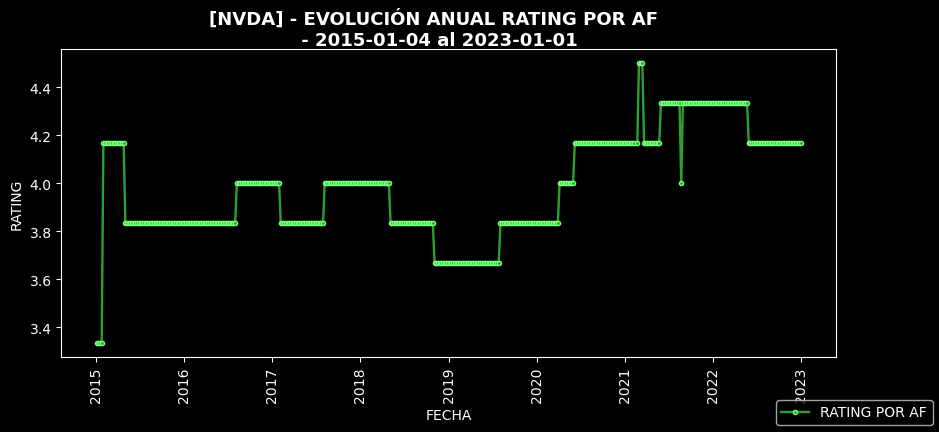

In [4]:
# getAFRating - output - chart
fig

In [5]:
# getAFRating - output - data
data

,ratingTotal,recomendacion
date,,
2015-01-04,3.3340,Neutral
2015-01-11,3.3340,Neutral
2015-01-18,3.3340,Neutral
2015-01-25,3.3340,Neutral
2015-02-01,4.1675,Buy
...,...,...
2022-12-04,4.1675,Buy
2022-12-11,4.1675,Buy
2022-12-18,4.1675,Buy


In [7]:
df, fig, df2, msg = getRecommendationFH(symbol = "NVDA")

In [8]:
# getRecommendationFH - output - dataframe
df

,buy,hold,sell,strongBuy,strongSell,totalPonderado,puntajeMaximo,puntajeFinalBase10
period,,,,,,,,
2023-10-01,36,3,0,20,0,135,177,7.63
2023-11-01,36,3,0,20,0,135,177,7.63
2023-12-01,35,4,0,21,0,137,180,7.61
2024-01-01,36,4,0,20,0,136,180,7.56


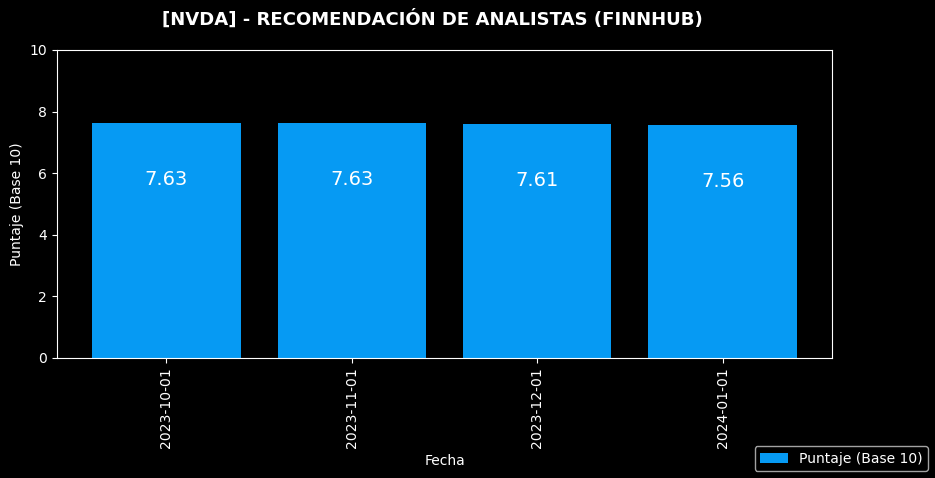

In [9]:
# getRecommendationFH - output - chart
fig

In [10]:
# getRecommendationFH - output - dataframe2
df2

,cantRecomend,%strongBuy,%buy,%hold,%sell,%strongSell
period,,,,,,
2023-10-01,59,33.90,61.02,5.08,0.0,0.0
2023-11-01,59,33.90,61.02,5.08,0.0,0.0
2023-12-01,60,35.00,58.33,6.67,0.0,0.0
2024-01-01,60,33.33,60.00,6.67,0.0,0.0


In [11]:
# getRecommendationFH - output - msg
msg

'Al 2024-01-01 el 33.33% recomienda fuertemente comprar, el 60.0% recomienda comprar, el 6.67% recomienda mantener, el 0.0% recomienda vender, y el 0.0% recomienda fuertemente vender.'